# **Assignment Roadmap**

This assignment asks you to build a complete Brain-Computer Interface (BCI) pipeline. Your goal is to take raw, noisy electrical brain signals and turn them into a clear Yes/No decision: Is this the character the user wants?

**Theres not much theory to learn other than implementation, you have to learn this by doing**

## AI Usage Policy for This Assignment

You're welcome to use AI for this assignment. Given the complexity of EEG signal processing and machine learning,
We don't expect you to know every implementation detail from scratch and neither does any recuiter or any professor.


Use AI to:

    Debug errors and troubleshoot issues

    Understand concepts and explore different approaches

What matters:

    You understand your code and can explain how it works

    You learn from the process, not just copy-paste

### **1: Cleaning the Signal (Preprocessing)**

The Goal: Raw EEG data is full of "garbage" frequencies like muscle movement and electrical hum. You need to filter the data to keep only the brain waves relevant to the P300 response (typically 0.1Hz – 20Hz).

You have already done this in the previous assignment but this one is a more standard procedure.

Common Pitfalls:

    Filter Lag: Standard filters can delay the signal, meaning the brain response looks like it happened later than it actually did. To prevent this, use zero-phase filtering (e.g., scipy.signal.filtfilt) instead of standard filtering (lfilter).

    Aliasing: You are asked to downsample the data from 240Hz to 60Hz to make it faster to process. Do not simply slice the array (e.g., data[::4]) without filtering first. If you do, high-frequency noise will "fold over" into your low frequencies and corrupt the data. Always filter before downsampling.

### **2: Epoch Extraction**

The Goal: You need to convert the continuous stream of data into specific "events" or "epochs."

The Concept: A P300 response happens roughly 300ms after a flash. Your code needs to identify every moment a flash occurs (stimulus_onset), look forward in time (e.g., 800ms), and "snip" that window of data out.

Visualizing the Data Structure:

    Input: A continuous 2D matrix (Total_Time_Points, 64_Channels)

    Output: A 3D block of events (Number_of_Flashes, Time_Points_Per_Window, 64_Channels)

Common Pitfall:

    Indexing Errors: This dataset may originate from MATLAB (which uses 1-based indexing), while Python uses 0-based indexing. If your index calculation is off by even one sample, your window will shift, and the machine learning model will be training on random noise rather than the brain response. Double-check your start and end indices.

### **3: Making Data "Model-Ready" (Feature Engineering)**

The Goal: Standard Machine Learning models (like SVM or LDA) cannot understand 3D arrays. They generally require a 2D matrix (like an Excel sheet). The Task:

    Time Domain: You will need to "flatten" the epochs. If an epoch is 60 time points × 64 channels, it becomes a single flat row of 3,840 numbers.

    PCA/CSP: These are compression techniques. The goal is to reduce those 3,840 numbers down to perhaps 20 numbers that capture the most important information.

Common Pitfall:

    Data Leakage: When using PCA or CSP, you must be careful not to "cheat." You should .fit() your reducer only on the training data, and then .transform() the test data. If you fit on the combined dataset, your model "sees" the test answers ahead of time, leading to artificially high scores that won't work in the real world.

### **4: Classification**

The Goal: Feed your features into the ML models (LDA, SVM, etc.) provided in the skeleton code to classify "Target" vs. "Non-Target" flashes.

Common Pitfall:

    Class Imbalance: In a P300 speller, the letter the user wants (Target) only flashes 1 out of 6 times. The other 5 flashes are Non-Targets.

        If your model decides to simply guess "Non-Target" every single time, it will still achieve ~83% accuracy. This is a useless model.

        Do not rely solely on Accuracy. Check the F1-Score or the Confusion Matrix. A good model must be able to correctly identify the rare Target events, not just the frequent Non-Targets.

In [1]:
!pip install mne

In [2]:
# The assignment is structured in a way that its modular so thats its easier to debug whats wrong

# ========================================================================
# STEP 0: ALL LIBRARIES
# ========================================================================
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import butter, filtfilt, iirnotch
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
import pickle
import json
import time
import warnings
warnings.filterwarnings('ignore')
import mne
from google.colab import drive

In [3]:
################################################################################
# SECTION 1: DATA LOADING AND BASIC SETUP
################################################################################

# Character matrix (6x6) for P300 speller
CHAR_MATRIX = np.array([
    ['A', 'B', 'C', 'D', 'E', 'F'],
    ['G', 'H', 'I', 'J', 'K', 'L'],
    ['M', 'N', 'O', 'P', 'Q', 'R'],
    ['S', 'T', 'U', 'V', 'W', 'X'],
    ['Y', 'Z', '1', '2', '3', '4'],
    ['5', '6', '7', '8', '9', '_']
])

def load_data(file_path):
    """
    Load P300 BCI Competition III data
    Returns dictionary with signal, flashing, stimulus_code, stimulus_type, target_char
    """
    print(f"Loading data from: {file_path}")

    try:
        # Load .mat file
        mat_data = sio.loadmat(file_path)

        # Create data dictionary with available fields
        data_dict = {}

        # Always available fields
        data_dict['signal'] = mat_data['Signal']  # 3D: (epochs, samples, channels)
        data_dict['flashing'] = mat_data['Flashing']
        data_dict['stimulus_code'] = mat_data['StimulusCode']

        # Check if StimulusType exists (only in training data)
        if 'StimulusType' in mat_data:
            data_dict['stimulus_type'] = mat_data['StimulusType']
            print("  ✓ StimulusType found (training data)")
        else:
            data_dict['stimulus_type'] = None
            print("  ⚠ StimulusType not found (test data)")

        # Check if TargetChar exists (only in training data)
        if 'TargetChar' in mat_data:
            data_dict['target_char'] = mat_data['TargetChar']
            print("  ✓ TargetChar found (training data)")
        else:
            data_dict['target_char'] = None
            print("  ⚠ TargetChar not found (test data)")

        # Debug: Show data structure
        print(f"  Signal shape: {data_dict['signal'].shape}")
        print(f"  Flashing shape: {data_dict['flashing'].shape}")
        print(f"  StimulusCode shape: {data_dict['stimulus_code'].shape}")
        if data_dict['stimulus_type'] is not None:
            print(f"  StimulusType shape: {data_dict['stimulus_type'].shape}")

        return data_dict

    except Exception as e:
        print(f"✗ Error loading data: {e}")
        # Try to see what keys are available
        print(f"  Available keys in .mat file: {list(mat_data.keys())}")
        return None


def get_char_from_codes(row_code, col_code):
    """Convert row/column stimulus codes to character"""
    # Rows: codes 1-6, Columns: codes 7-12
    if 1 <= row_code <= 6 and 7 <= col_code <= 12:
        row_idx = row_code - 1
        col_idx = col_code - 7
        return CHAR_MATRIX[row_idx, col_idx]
    return None

In [4]:
################################################################################
# SECTION 2: EEG SIGNAL ACQUISITION & PREPROCESSING
################################################################################

def bandpass_filter(signal, lowcut=0.1, highcut=20, fs=240, order=5):
    """
    Apply band-pass filter to remove low-frequency drift and high-frequency noise
    Typical P300 band: 0.1-20 Hz
    """
    print(f"Applying bandpass filter: {lowcut}-{highcut} Hz, order={order}")

    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # Create Butterworth filter
    b, a = butter(order, [low, high], btype='band')

    # Apply filter
    filtered_signal = filtfilt(b, a, signal, axis=0)

    print(f"  Input shape: {signal.shape}, Output shape: {filtered_signal.shape}")
    return filtered_signal


def notch_filter(signal, freq=50, fs=240, Q=30):
    """
    Remove powerline interference (50/60 Hz)
    """
    print(f"Applying notch filter at {freq} Hz, Q={Q}")

    # Design notch filter
    b, a = iirnotch(freq, Q, fs)

    # Apply filter
    filtered_signal = filtfilt(b, a, signal, axis=0)

    return filtered_signal


def baseline_correction(epoch, baseline_samples=50):
    """
    Apply baseline correction by subtracting pre-stimulus baseline
    """
    # Calculate mean of pre-stimulus baseline
    baseline_mean = np.mean(epoch[:baseline_samples], axis=0)

    # Subtract baseline from entire epoch
    corrected_epoch = epoch - baseline_mean

    return corrected_epoch


def downsample_signal(signal, original_fs=240, target_fs=60):
    """
    Downsample signal to reduce computational load
    240 Hz -> 60 Hz reduces data by 4x
    """
    print(f"Downsampling from {original_fs} Hz to {target_fs} Hz")

    if len(signal.shape) == 3:  # 3D data (epochs, samples, channels)
        n_epochs, n_samples, n_channels = signal.shape
        downsampling_factor = int(original_fs / target_fs)
        new_n_samples = n_samples // downsampling_factor

        # Reshape to 2D for easier processing
        signal_2d = signal.reshape(n_epochs * n_samples, n_channels)

        # Downsample using slicing
        downsampled_2d = signal_2d[::downsampling_factor, :]

        # Reshape back to 3D
        downsampled_signal = downsampled_2d.reshape(n_epochs, new_n_samples, n_channels)

    else:  # 2D data (samples, channels)
        downsampling_factor = int(original_fs / target_fs)
        downsampled_signal = signal[::downsampling_factor, :]

    print(f"  Original shape: {signal.shape}, Downsampled shape: {downsampled_signal.shape}")
    return downsampled_signal, target_fs


def artifact_rejection(signal, threshold=100):
    """
    Simple artifact rejection based on amplitude threshold (in μV)
    """
    print(f"Applying artifact rejection with threshold: {threshold} μV")

    # Convert to absolute values
    abs_signal = np.abs(signal)

    # Find epochs/channels exceeding threshold
    if len(signal.shape) == 3:  # 3D: epochs
        bad_epochs = np.any(np.any(abs_signal > threshold, axis=2), axis=1)
        print(f"  Found {np.sum(bad_epochs)} bad epochs out of {len(bad_epochs)}")

        # Keep only good epochs
        clean_signal = signal[~bad_epochs, :, :]

    else:  # 2D: continuous
        bad_samples = np.any(abs_signal > threshold, axis=1)
        print(f"  Found {np.sum(bad_samples)} bad samples out of {len(bad_samples)}")

        # Keep only good samples
        clean_signal = signal[~bad_samples, :]

    print(f"  Clean signal shape: {clean_signal.shape}")
    return clean_signal


def preprocess_pipeline(data, apply_bandpass=True, apply_notch=True,
                       apply_downsample=True, apply_artifact_rejection=False,
                       fs=240, verbose=True):
    """
    Complete preprocessing pipeline:
    1. Bandpass filtering (0.1-20 Hz)
    2. Notch filtering (50 Hz)
    3. Downsampling (240->120 Hz)
    4. Optional artifact rejection
    """
    if verbose:
        print("\n" + "="*50)
        print("PREPROCESSING PIPELINE")
        print("="*50)

    # Extract signal from data dictionary
    signal = data['signal'].copy()
    n_epochs, n_samples, n_channels = signal.shape
    print(f"Input signal shape: {signal.shape}")
    print(f"Total samples: {n_epochs * n_samples:,}")
    print(f"Channels: {n_channels}")

    # Reshape to 2D for filtering (epochs x samples, channels)
    original_shape = signal.shape
    signal_2d = signal.reshape(-1, n_channels)
    print(f"Reshaped to 2D: {signal_2d.shape}")

    # Step 1: Bandpass filter
    if apply_bandpass:
        signal_2d = bandpass_filter(signal_2d, lowcut=0.1, highcut=20, fs=fs, order=4)

    # Step 2: Notch filter
    if apply_notch:
        signal_2d = notch_filter(signal_2d, freq=50, fs=fs, Q=30)

    # Step 3: Artifact rejection
    if apply_artifact_rejection:
        signal_2d = artifact_rejection(signal_2d, threshold=100)

    # Reshape back to 3D
    if apply_artifact_rejection:
        # After artifact rejection, need to handle variable length
        n_total_samples = signal_2d.shape[0]
        n_epochs_new = n_total_samples // n_samples
        signal_3d = signal_2d[:n_epochs_new * n_samples, :].reshape(n_epochs_new, n_samples, n_channels)
    else:
        signal_3d = signal_2d.reshape(original_shape)

    # Step 4: Downsampling
    new_fs = fs
    if apply_downsample and fs == 240:
        signal_3d, new_fs = downsample_signal(signal_3d, original_fs=fs, target_fs=120)

    print(f"\nPreprocessing complete:")
    print(f"  Original shape: {original_shape}")
    print(f"  Processed shape: {signal_3d.shape}")
    print(f"  Sampling rate: {new_fs} Hz")

    # Create processed data dictionary
    processed_data = {
        'signal': signal_3d,
        'flashing': data['flashing'],
        'stimulus_code': data['stimulus_code'],
        'stimulus_type': data['stimulus_type'],  # Could be None for test data
        'target_char': data['target_char'],      # Could be None for test data
        'fs': new_fs
    }

    return processed_data


def extract_epochs(data, epoch_length_ms=800, baseline_ms=100, fs=60):
    """
    Extract epochs around stimulus onset
    Returns: Dictionary with epochs, labels (if available), codes, character indices
    """
    print(f"\nExtracting epochs:")
    print(f"  Epoch length: {epoch_length_ms} ms")
    print(f"  Baseline: {baseline_ms} ms")
    print(f"  Sampling rate: {fs} Hz")

    # Calculate sample indices
    epoch_samples = int(epoch_length_ms * fs / 1000)
    baseline_samples = int(baseline_ms * fs / 1000)

    # Get data
    signal = data['signal']
    flashing = data['flashing']
    stimulus_code = data['stimulus_code']
    stimulus_type = data['stimulus_type']  # Could be None for test data

    n_epochs_total, n_samples_total, n_channels = signal.shape

    print(f"  Total trials: {n_epochs_total}")
    print(f"  Samples per trial: {n_samples_total}")
    print(f"  Channels: {n_channels}")

    # Flatten markers across trials
    flashing_flat = flashing.flatten()
    stimulus_code_flat = stimulus_code.flatten()

    print(f"\n  Flattened markers:")
    print(f"    Flashing shape: {flashing_flat.shape}")
    print(f"    StimulusCode shape: {stimulus_code_flat.shape}")

    # Handle stimulus_type if available
    if stimulus_type is not None:
        stimulus_type_flat = stimulus_type.flatten()
        print(f"    StimulusType shape: {stimulus_type_flat.shape}")
        has_labels = True
    else:
        print(f"    StimulusType: Not available (test data)")
        has_labels = False

    # Find stimulus onsets (flashing goes from 0 to 1)
    flashing_diff = np.diff(flashing_flat)
    onset_indices = np.where(flashing_diff == 1)[0] + 1

    print(f"\n  Found {len(onset_indices)} stimulus onsets")
    print(f"  Will process all onsets...")

    # Initialize lists
    epochs_list = []
    labels_list = [] if has_labels else None
    codes_list = []
    char_idx_list = []

    # Track for debugging
    skipped_epochs = 0
    processed_epochs = 0

    # Convert continuous signal to 2D for easier indexing
    signal_2d = signal.reshape(-1, n_channels)

    # Extract epochs around each onset
    for i, onset_idx in enumerate(onset_indices):

        # Check if we have enough samples after onset
        if onset_idx + epoch_samples - baseline_samples <= signal_2d.shape[0]:

            # Extract epoch (include baseline before onset)
            start_idx = onset_idx - baseline_samples
            end_idx = onset_idx + epoch_samples - baseline_samples

            epoch_data = signal_2d[start_idx:end_idx, :]

            # Apply baseline correction
            if baseline_samples > 0:
                baseline_mean = np.mean(epoch_data[:baseline_samples], axis=0)
                epoch_data = epoch_data - baseline_mean

            epochs_list.append(epoch_data)

            # Get stimulus information
            code = stimulus_code_flat[onset_idx]
            codes_list.append(code)

            # Get label if available
            if has_labels:
                stype = stimulus_type_flat[onset_idx]
                label = 1 if stype == 1 else 0
                labels_list.append(label)

            # For training data, track character indices
            if data['target_char'] is not None:
                # Find which character this epoch belongs to
                char_idx = i // 12  # 12 flashes per character
                char_idx_list.append(char_idx)

            processed_epochs += 1

        else:
            skipped_epochs += 1

        # Progress update for large datasets
        if (i + 1) % 1000 == 0:
            print(f"    Processed {i + 1}/{len(onset_indices)} onsets...")

    print(f"\n  Successfully extracted {processed_epochs} epochs")
    print(f"  Skipped {skipped_epochs} epochs (insufficient data)")

    # Convert to numpy arrays
    epochs_array = np.array(epochs_list)
    codes_array = np.array(codes_list)

    print(f"\n  Final epoch data structure:")
    print(f"    Epochs shape: {epochs_array.shape}")
    print(f"    Codes shape: {codes_array.shape}")

    # Create return dictionary
    epoch_data = {
        'epochs': epochs_array,
        'codes': codes_array,
        'fs': fs,
        'epoch_samples': epoch_samples,
        'baseline_samples': baseline_samples,
        'has_labels': has_labels
    }

    # Add labels if available
    if has_labels and labels_list:
        labels_array = np.array(labels_list)
        epoch_data['labels'] = labels_array
        print(f"    Labels shape: {labels_array.shape}")

    # Add character indices if available
    if char_idx_list:
        char_idx_array = np.array(char_idx_list)
        epoch_data['char_indices'] = char_idx_array
        print(f"    Character indices shape: {char_idx_array.shape}")

    return epoch_data

def plot_erp_responses(epoch_data, channel_idx=31, fs=60):
    """
    Visualize ERP responses and confirm P300 peaks around 300ms
    Channel 31 = Cz (central midline electrode, best for P300)
    """
    print(f"\nPlotting ERP responses for channel {channel_idx}")

    epochs = epoch_data['epochs']

    # Check if we have labels
    if 'labels' in epoch_data and epoch_data['labels'] is not None:
        labels = epoch_data['labels']
        has_labels = True
    else:
        print("  ⚠ No labels available (test data). Plotting all epochs together.")
        has_labels = False

    if has_labels:
        # Separate target and non-target epochs
        target_epochs = epochs[labels == 1]
        nontarget_epochs = epochs[labels == 0]

        print(f"  Target epochs: {len(target_epochs)}")
        print(f"  Non-target epochs: {len(nontarget_epochs)}")

        # Calculate averages
        target_avg = np.mean(target_epochs, axis=0)
        nontarget_avg = np.mean(nontarget_epochs, axis=0)

        # Calculate standard error
        target_se = np.std(target_epochs, axis=0) / np.sqrt(len(target_epochs))
        nontarget_se = np.std(nontarget_epochs, axis=0) / np.sqrt(len(nontarget_epochs))

        # Create time axis
        n_samples = target_avg.shape[0]
        time_axis = np.arange(n_samples) * 1000 / fs  # Convert to ms

        # Plot averages with standard error
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.plot(time_axis, target_avg[:, channel_idx], 'r-', linewidth=2, label='Target')
        plt.fill_between(time_axis,
                         target_avg[:, channel_idx] - target_se[:, channel_idx],
                         target_avg[:, channel_idx] + target_se[:, channel_idx],
                         alpha=0.3, color='red')

        plt.plot(time_axis, nontarget_avg[:, channel_idx], 'b-', linewidth=2, label='Non-target')
        plt.fill_between(time_axis,
                         nontarget_avg[:, channel_idx] - nontarget_se[:, channel_idx],
                         nontarget_avg[:, channel_idx] + nontarget_se[:, channel_idx],
                         alpha=0.3, color='blue')

        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude (μV)')
        plt.title(f'ERP Responses - Channel {channel_idx}')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Mark P300 peak region
        p300_start = 250  # ms
        p300_end = 500    # ms
        plt.axvspan(p300_start, p300_end, alpha=0.2, color='yellow', label='P300 window')
        plt.legend()

        # Plot difference wave
        plt.subplot(1, 2, 2)
        difference = target_avg[:, channel_idx] - nontarget_avg[:, channel_idx]
        plt.plot(time_axis, difference, 'g-', linewidth=2, label='Target - Non-target')
        plt.xlabel('Time (ms)')
        plt.ylabel('Difference (μV)')
        plt.title('Difference Wave')
        plt.grid(True, alpha=0.3)

        # Mark P300 region
        p300_idx = np.where((time_axis >= p300_start) & (time_axis <= p300_end))[0]
        if len(p300_idx) > 0:
            p300_amplitude = np.max(difference[p300_idx])
            p300_latency = time_axis[p300_idx[np.argmax(difference[p300_idx])]]
            plt.axvline(p300_latency, color='r', linestyle='--',
                       label=f'P300 peak: {p300_latency:.1f} ms')
            plt.text(p300_latency, p300_amplitude,
                    f'{p300_amplitude:.2f} μV', ha='center', va='bottom')

        plt.legend()
        plt.tight_layout()
        plt.show()

        # Calculate P300 amplitude difference
        p300_window_idx = np.where((time_axis >= 300) & (time_axis <= 500))[0]
        if len(p300_window_idx) > 0:
            target_p300 = np.mean(target_avg[p300_window_idx, channel_idx])
            nontarget_p300 = np.mean(nontarget_avg[p300_window_idx, channel_idx])
            p300_difference = target_p300 - nontarget_p300

            print(f"\nP300 Analysis (300-500ms window):")
            print(f"  Target average: {target_p300:.2f} μV")
            print(f"  Non-target average: {nontarget_p300:.2f} μV")
            print(f"  Difference: {p300_difference:.2f} μV")

            if p300_difference > 2:  # Arbitrary threshold
                print("  ✓ Clear P300 response detected!")
            else:
                print("  ⚠ Weak or no P300 response detected")

        return target_avg, nontarget_avg

    else:
        # Plot all epochs average for test data
        all_avg = np.mean(epochs, axis=0)
        all_se = np.std(epochs, axis=0) / np.sqrt(len(epochs))

        # Create time axis
        n_samples = all_avg.shape[0]
        time_axis = np.arange(n_samples) * 1000 / fs

        plt.figure(figsize=(10, 6))
        plt.plot(time_axis, all_avg[:, channel_idx], 'k-', linewidth=2, label='All epochs')
        plt.fill_between(time_axis,
                         all_avg[:, channel_idx] - all_se[:, channel_idx],
                         all_avg[:, channel_idx] + all_se[:, channel_idx],
                         alpha=0.3, color='gray')

        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude (μV)')
        plt.title(f'Average ERP - Channel {channel_idx} (Test Data)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Mark P300 region
        plt.axvspan(250, 500, alpha=0.2, color='yellow', label='P300 window')
        plt.legend()
        plt.tight_layout()
        plt.show()

        return all_avg, None

In [5]:
################################################################################
# SECTION 3: FEATURE ENGINEERING & BASELINE CLASSIFIERS
################################################################################

def extract_time_domain_features(epochs):
    """
    Extract time-domain features: simply flatten the epochs
    Shape: (n_epochs, n_samples * n_channels)
    """
    print(f"Extracting time-domain features...")
    n_epochs, n_samples, n_channels = epochs.shape
    features = epochs.reshape(n_epochs, n_samples * n_channels)
    print(f"  Input shape: {epochs.shape}")
    print(f"  Output shape: {features.shape}")
    print(f"  Features per epoch: {features.shape[1]}")
    return features


def extract_pca_features(epochs, n_components=20):
    """
    Extract PCA features for dimensionality reduction
    Reduces (n_samples * n_channels) to n_components
    """
    print(f"Extracting PCA features (n_components={n_components})...")

    # Flatten epochs first
    n_epochs, n_samples, n_channels = epochs.shape
    flattened = epochs.reshape(n_epochs, n_samples * n_channels)
    print(f"  Flattened shape: {flattened.shape}")

    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(flattened)

    # Apply PCA
    pca = PCA(n_components=n_components, random_state=42)
    pca_features = pca.fit_transform(data_scaled)

    print(f"  PCA features shape: {pca_features.shape}")
    print(f"  Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")

    return pca_features, pca


def extract_csp_features(epochs, labels, n_components=6):
    """
    Common Spatial Patterns (CSP) for discriminative spatial filters
    Finds spatial filters that maximize variance ratio between classes
    """
    print(f"Extracting CSP features (n_components={n_components})...")

    target_epochs = epochs[labels == 1]
    non_target_epochs = epochs[labels == 0]
    print(f"  Target epochs for CSP: {len(target_epochs)}")
    print(f"  Non-target epochs for CSP: {len(non_target_epochs)}")

    # Compute covariance matrices
    def compute_cov(data):
        # data shape: (n_epochs, n_samples, n_channels)
        n_epochs = data.shape[0]
        cov_sum = np.zeros((data.shape[2], data.shape[2]))

        for i in range(n_epochs):
            # For each epoch, compute covariance
            epoch = data[i]
            # Normalize by number of samples
            cov = np.cov(epoch.T)
            cov_sum += cov

        return cov_sum / n_epochs

    # Compute class covariance matrices
    cov_target = compute_cov(target_epochs)
    cov_nontarget = compute_cov(non_target_epochs)

    # Solve generalized eigenvalue problem
    # Solve: cov_target * w = lambda * (cov_target + cov_nontarget) * w
    cov_combined = cov_target + cov_nontarget

    # Ensure matrices are symmetric
    cov_target = (cov_target + cov_target.T) / 2
    cov_combined = (cov_combined + cov_combined.T) / 2

    # Add small regularization for numerical stability
    reg_coeff = 1e-4
    cov_combined += reg_coeff * np.eye(cov_combined.shape[0])

    # Solve eigenvalue problem
    eigenvalues, eigenvectors = eigh(cov_target, cov_combined)

    # Sort by eigenvalues (descending)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Select most discriminative components (extreme eigenvalues)
    # First m and last m components
    m = n_components // 2
    selected_indices = list(range(m)) + list(range(-m, 0))
    selected_filters = eigenvectors[:, selected_indices]

    print(f"  Selected {len(selected_indices)} CSP filters")
    print(f"  Eigenvalues of selected filters: {eigenvalues[selected_indices]}")

    # Extract CSP features (log variance)
    csp_features = []
    for epoch in epochs:
        # Apply CSP filters
        filtered_epoch = selected_filters.T @ epoch.T  # Shape: (n_components, n_samples)

        # Compute variance along time axis
        variances = np.var(filtered_epoch, axis=1)

        # Log transform (add small constant to avoid log(0))
        log_variances = np.log(variances + 1e-10)

        csp_features.append(log_variances)

    csp_features = np.array(csp_features)
    print(f"  CSP features shape: {csp_features.shape}")

    return csp_features, selected_filters


def extract_features(epoch_data, method='pca', n_components=20):
    """
    Feature extraction wrapper supporting multiple methods:
    - time_domain: Raw time-domain samples (flattened)
    - pca: Principal Component Analysis
    - csp: Common Spatial Patterns
    """
    print(f"\nExtracting features using method: {method}")

    epochs = epoch_data['epochs']

    if method == 'time':
        features = extract_time_domain_features(epochs)
        return features, None

    elif method == 'pca':
        features, pca_obj = extract_pca_features(epochs, n_components=n_components)
        return features, pca_obj

    elif method == 'csp':
        if 'labels' not in epoch_data or epoch_data['labels'] is None:
            print("  Error: CSP requires labels for training!")
            return None, None
        features, csp_filters = extract_csp_features(epochs, epoch_data['labels'],
                                                    n_components=n_components)
        return features, csp_filters

    else:
        print(f"  Error: Unknown method '{method}'")
        return None, None


class CSPTransformer:
    """
    Wrapper for CSP filters to enable transform() method
    """
    def __init__(self, csp_filters):
        self.csp_filters = csp_filters

    def transform(self, epochs):
        csp_features = []
        for epoch in epochs:
            filtered_epoch = self.csp_filters.T @ epoch.T
            variances = np.var(filtered_epoch, axis=1)
            log_variances = np.log(variances + 1e-10)
            csp_features.append(log_variances)
        return np.array(csp_features)


def train_lda_classifier(X_train, y_train):
    """
    Linear Discriminant Analysis with balanced priors
    """
    print("\n  Training LDA Classifier...")

    # Calculate class priors
    n_target = np.sum(y_train == 1)
    n_nontarget = np.sum(y_train == 0)
    total = len(y_train)

    # Use balanced priors (since we have class imbalance)
    lda = LinearDiscriminantAnalysis(priors=[n_nontarget/total, n_target/total])

    # Train
    lda.fit(X_train, y_train)

    print(f"    Training samples: {len(y_train)}")
    print(f"    Target: {n_target}, Non-target: {n_nontarget}")
    print(f"    Priors: [{lda.priors_[0]:.4f}, {lda.priors_[1]:.4f}]")

    return lda


def train_logistic_regression(X_train, y_train):
    """
    Logistic Regression - baseline classifier
    """
    print("\n  Training Logistic Regression...")

    # Use class_weight='balanced' to handle imbalance
    lr = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        solver='liblinear'
    )

    # Train
    lr.fit(X_train, y_train)

    print(f"    Training samples: {len(y_train)}")
    print(f"    Target: {np.sum(y_train == 1)}, Non-target: {np.sum(y_train == 0)}")
    print(f"    Coefficients shape: {lr.coef_.shape}")

    return lr


def evaluate_classifier(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive classifier evaluation
    """
    print(f"\n  Evaluating {model_name}...")

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"    Accuracy:  {accuracy:.4f}")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall:    {recall:.4f}")
    print(f"    F1-score:  {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"    Confusion Matrix:")
    print(f"      [[TN:{cm[0,0]:4d}  FP:{cm[0,1]:4d}]")
    print(f"       [FN:{cm[1,0]:4d}  TP:{cm[1,1]:4d}]]")

    # ROC-AUC if probabilities available
    if y_pred_proba is not None:
        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            print(f"    ROC-AUC:   {roc_auc:.4f}")
        except:
            pass

    return accuracy, f1, precision, recall

In [6]:
################################################################################
# SECTION 4: CLASSICAL MACHINE LEARNING MODELS
################################################################################

def train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0):
    """
    Support Vector Machine with RBF kernel
    Good for non-linear decision boundaries
    """
    print(f"\n  Training SVM Classifier (kernel={kernel}, C={C})...")

    # Standardize features for SVM
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Use balanced class weights
    svm = SVC(
        kernel=kernel,
        C=C,
        class_weight='balanced',
        probability=True,
        random_state=42,
        verbose=0
    )

    # Train
    svm.fit(X_train_scaled, y_train)

    print(f"    Training samples: {len(y_train)}")
    print(f"    Target: {np.sum(y_train == 1)}, Non-target: {np.sum(y_train == 0)}")
    print(f"    Support vectors per class: {svm.n_support_}")

    return svm, scaler


def train_random_forest(X_train, y_train, n_estimators=100):
    """
    Random Forest Classifier
    Ensemble method, robust to overfitting
    """
    print(f"\n  Training Random Forest (n_estimators={n_estimators})...")

    # Use balanced class weights
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        class_weight='balanced',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    # Train
    rf.fit(X_train, y_train)

    print(f"    Training samples: {len(y_train)}")
    print(f"    Target: {np.sum(y_train == 1)}, Non-target: {np.sum(y_train == 0)}")
    print(f"    Feature importance shape: {rf.feature_importances_.shape}")

    return rf


def train_gradient_boosting(X_train, y_train, n_estimators=100):
    """
    Gradient Boosting Classifier with manual sample weighting
    """
    print(f"\n  Training Gradient Boosting (n_estimators={n_estimators})...")

    # Calculate sample weights manually for class imbalance
    n_target = np.sum(y_train == 1)
    n_nontarget = np.sum(y_train == 0)
    total = len(y_train)

    sample_weights = np.ones(len(y_train))
    sample_weights[y_train == 1] = n_nontarget / total  # Upweight minority class
    sample_weights[y_train == 0] = n_target / total     # Downweight majority class

    # Normalize weights
    sample_weights = sample_weights / np.mean(sample_weights)

    # Train Gradient Boosting
    gb = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        verbose=0
    )

    gb.fit(X_train, y_train, sample_weight=sample_weights)

    print(f"    Training samples: {len(y_train)}")
    print(f"    Target: {n_target}, Non-target: {n_nontarget}")
    print(f"    Mean sample weight: {np.mean(sample_weights):.3f}")

    return gb


def compare_all_classical_models(X_train, y_train, X_test, y_test):
    """
    Train and compare all classical ML models
    Returns performance comparison
    """
    print("\n" + "="*60)
    print("COMPARING CLASSICAL ML MODELS")
    print("="*60)

    results = {}
    models = {}

    # Calculate sample weights once for methods that need it
    n_target = np.sum(y_train == 1)
    n_nontarget = np.sum(y_train == 0)

    # Define models to train
    model_configs = [
        ('LDA', lambda: train_lda_classifier(X_train, y_train)),
        ('Logistic Regression', lambda: train_logistic_regression(X_train, y_train)),
        ('SVM (RBF)', lambda: train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0)),
        ('SVM (Linear)', lambda: train_svm_classifier(X_train, y_train, kernel='linear', C=1.0)),
        ('Random Forest', lambda: train_random_forest(X_train, y_train, n_estimators=100)),
        ('Gradient Boosting', lambda: train_gradient_boosting(X_train, y_train, n_estimators=100))
    ]

    for model_name, train_func in model_configs:
        try:
            print(f"\n{'='*40}")
            print(f"Training {model_name}")
            print('='*40)

            # Training
            if model_name.startswith('SVM'):
                model, scaler = train_func()
                X_test_scaled = scaler.transform(X_test) if scaler else X_test
                models[model_name] = (model, scaler)

                # Inference
                y_pred = model.predict(X_test_scaled)
                y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
            else:
                model = train_func()
                models[model_name] = model

                # Inference
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

            # Metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            # ROC-AUC if available
            roc_auc = 0
            if y_pred_proba is not None:
                try:
                    roc_auc = roc_auc_score(y_test, y_pred_proba)
                except:
                    pass

            # Store results
            results[model_name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': roc_auc
            }

            print(f"\n{model_name} Results:")
            print(f"  Accuracy:  {accuracy:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall:    {recall:.4f}")
            print(f"  F1-score:  {f1:.4f}")
            if roc_auc > 0:
                print(f"  ROC-AUC:   {roc_auc:.4f}")

        except Exception as e:
            print(f"  Error training {model_name}: {e}")
            continue

    # Summary table
    print("\n" + "="*70)
    print("MODEL COMPARISON SUMMARY")
    print("="*70)
    print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'ROC-AUC':<10}")
    print("-" * 70)

    for model_name, metrics in results.items():
        print(f"{model_name:<20} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} "
              f"{metrics['recall']:<10.4f} {metrics['f1']:<10.4f} {metrics['roc_auc']:<10.4f}")

    return results, models


def save_model(model, filepath):
    """Save model to pickle file"""
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"\n  Model saved to: {filepath}")

def load_model(filepath):
    """Load model from pickle file"""
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"\n  Model loaded from: {filepath}")
    return model

In [7]:
# ========================================================================
# STEP 1: LOAD DATA
# ========================================================================
print("\n" + "="*70)
print("STEP 1: LOADING DATA")
print("="*70)

# Mount Google Drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/eea/dataset/'

# Load data for both subjects
print("\n--- Subject A Training ---")
train_data_A = load_data(DATA_PATH + 'Subject_A_Train.mat')

print("\n--- Subject A Test ---")
test_data_A = load_data(DATA_PATH + 'Subject_A_Test.mat')

print("\n--- Subject B Training ---")
train_data_B = load_data(DATA_PATH + 'Subject_B_Train.mat')

print("\n--- Subject B Test ---")
test_data_B = load_data(DATA_PATH + 'Subject_B_Test.mat')

# Verify data loading
if all([train_data_A is not None, test_data_A is not None,
        train_data_B is not None, test_data_B is not None]):
    print("\n✓ All datasets loaded successfully")
else:
    print("\n✗ Error loading some datasets")
    # Exit if any dataset failed to load
    exit(1)


STEP 1: LOADING DATA
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Subject A Training ---
Loading data from: /content/drive/MyDrive/eea/dataset/Subject_A_Train.mat
  ✓ StimulusType found (training data)
  ✓ TargetChar found (training data)
  Signal shape: (85, 7794, 64)
  Flashing shape: (85, 7794)
  StimulusCode shape: (85, 7794)
  StimulusType shape: (85, 7794)

--- Subject A Test ---
Loading data from: /content/drive/MyDrive/eea/dataset/Subject_A_Test.mat
  ⚠ StimulusType not found (test data)
  ⚠ TargetChar not found (test data)
  Signal shape: (100, 7794, 64)
  Flashing shape: (100, 7794)
  StimulusCode shape: (100, 7794)

--- Subject B Training ---
Loading data from: /content/drive/MyDrive/eea/dataset/Subject_B_Train.mat
  ✓ StimulusType found (training data)
  ✓ TargetChar found (training data)
  Signal shape: (85, 7794, 64)
  Flashing shape: (85, 7794)
  StimulusCode shape: (85, 7794)
  Sti

In [8]:
# ========================================================================
# STEP 2: PREPROCESSING
# ========================================================================
print("\n" + "="*70)
print("STEP 2: PREPROCESSING")
print("="*70)

print("\n--- Subject A Training ---")
train_proc_A = preprocess_pipeline(train_data_A)

print("\n--- Subject A Test ---")
test_proc_A = preprocess_pipeline(test_data_A)

print("\n--- Subject B Training ---")
train_proc_B = preprocess_pipeline(train_data_B)

print("\n--- Subject B Test ---")
test_proc_B = preprocess_pipeline(test_data_B)


STEP 2: PREPROCESSING

--- Subject A Training ---

PREPROCESSING PIPELINE
Input signal shape: (85, 7794, 64)
Total samples: 662,490
Channels: 64
Reshaped to 2D: (662490, 64)
Applying bandpass filter: 0.1-20 Hz, order=4
  Input shape: (662490, 64), Output shape: (662490, 64)
Applying notch filter at 50 Hz, Q=30
Downsampling from 240 Hz to 120 Hz
  Original shape: (85, 7794, 64), Downsampled shape: (85, 3897, 64)

Preprocessing complete:
  Original shape: (85, 7794, 64)
  Processed shape: (85, 3897, 64)
  Sampling rate: 120 Hz

--- Subject A Test ---

PREPROCESSING PIPELINE
Input signal shape: (100, 7794, 64)
Total samples: 779,400
Channels: 64
Reshaped to 2D: (779400, 64)
Applying bandpass filter: 0.1-20 Hz, order=4
  Input shape: (779400, 64), Output shape: (779400, 64)
Applying notch filter at 50 Hz, Q=30
Downsampling from 240 Hz to 120 Hz
  Original shape: (100, 7794, 64), Downsampled shape: (100, 3897, 64)

Preprocessing complete:
  Original shape: (100, 7794, 64)
  Processed shape

In [9]:
# ========================================================================
# STEP 3: EPOCH EXTRACTION
# ========================================================================
print("\n" + "="*70)
print("STEP 3: EPOCH EXTRACTION")
print("="*70)

print("\n--- Subject A Training ---")
train_epochs_A = extract_epochs(train_proc_A, fs=train_proc_A['fs'])

print("\n--- Subject A Test ---")
test_epochs_A = extract_epochs(test_proc_A, fs=test_proc_A['fs'])

print("\n--- Subject B Training ---")
train_epochs_B = extract_epochs(train_proc_B, fs=train_proc_B['fs'])

print("\n--- Subject B Test ---")
test_epochs_B = extract_epochs(test_proc_B, fs=test_proc_B['fs'])



STEP 3: EPOCH EXTRACTION

--- Subject A Training ---

Extracting epochs:
  Epoch length: 800 ms
  Baseline: 100 ms
  Sampling rate: 120 Hz
  Total trials: 85
  Samples per trial: 3897
  Channels: 64

  Flattened markers:
    Flashing shape: (662490,)
    StimulusCode shape: (662490,)
    StimulusType shape: (662490,)

  Found 15299 stimulus onsets
  Will process all onsets...
    Processed 1000/15299 onsets...
    Processed 2000/15299 onsets...
    Processed 3000/15299 onsets...
    Processed 4000/15299 onsets...
    Processed 5000/15299 onsets...
    Processed 6000/15299 onsets...
    Processed 7000/15299 onsets...
    Processed 8000/15299 onsets...
    Processed 9000/15299 onsets...
    Processed 10000/15299 onsets...
    Processed 11000/15299 onsets...
    Processed 12000/15299 onsets...
    Processed 13000/15299 onsets...
    Processed 14000/15299 onsets...
    Processed 15000/15299 onsets...

  Successfully extracted 7650 epochs
  Skipped 7649 epochs (insufficient data)

  Final 


STEP 4: VISUALIZING ERP RESPONSES

--- Subject A Training ---

Plotting ERP responses for channel 31
  Target epochs: 1275
  Non-target epochs: 6375


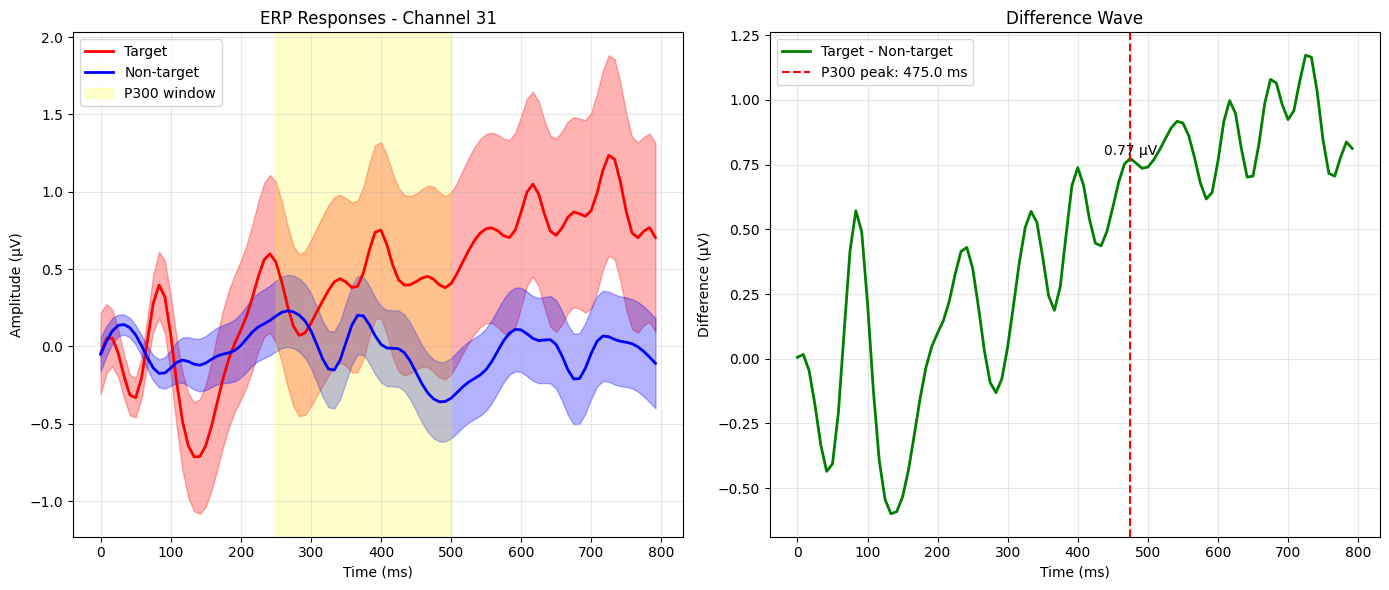


P300 Analysis (300-500ms window):
  Target average: 0.44 μV
  Non-target average: -0.07 μV
  Difference: 0.51 μV
  ⚠ Weak or no P300 response detected

--- Subject B Training ---

Plotting ERP responses for channel 31
  Target epochs: 1275
  Non-target epochs: 6375


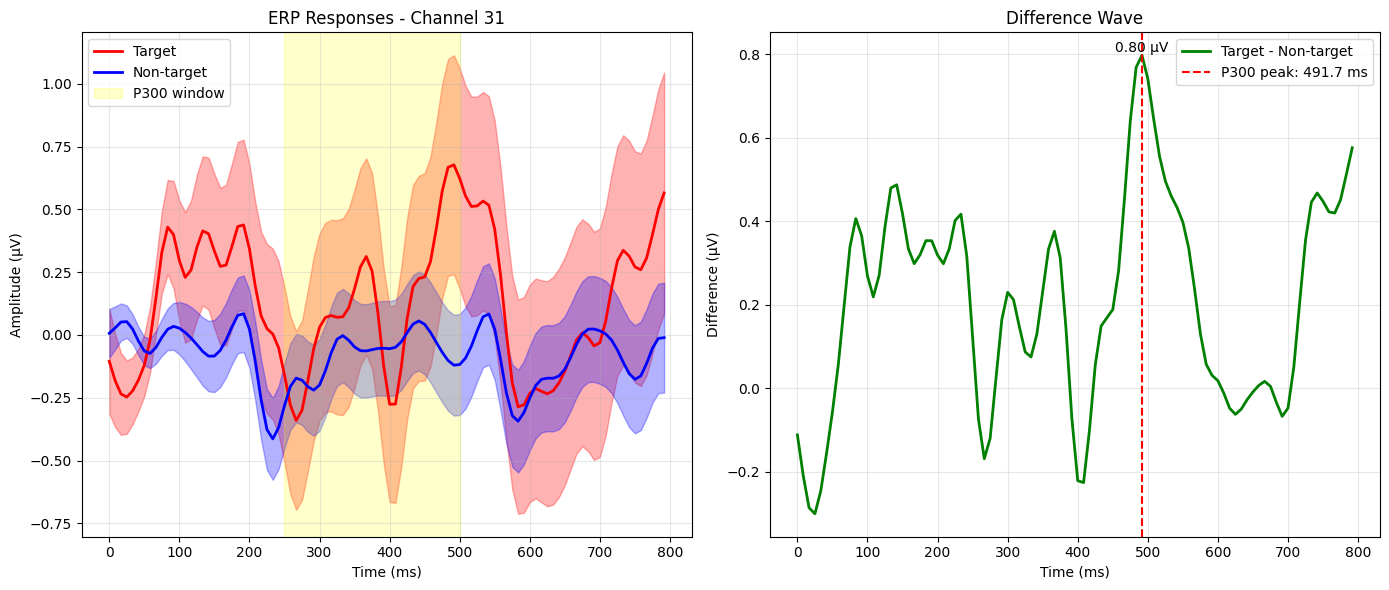


P300 Analysis (300-500ms window):
  Target average: 0.19 μV
  Non-target average: -0.05 μV
  Difference: 0.24 μV
  ⚠ Weak or no P300 response detected

--- Subject A Test ---

Plotting ERP responses for channel 31
  ⚠ No labels available (test data). Plotting all epochs together.


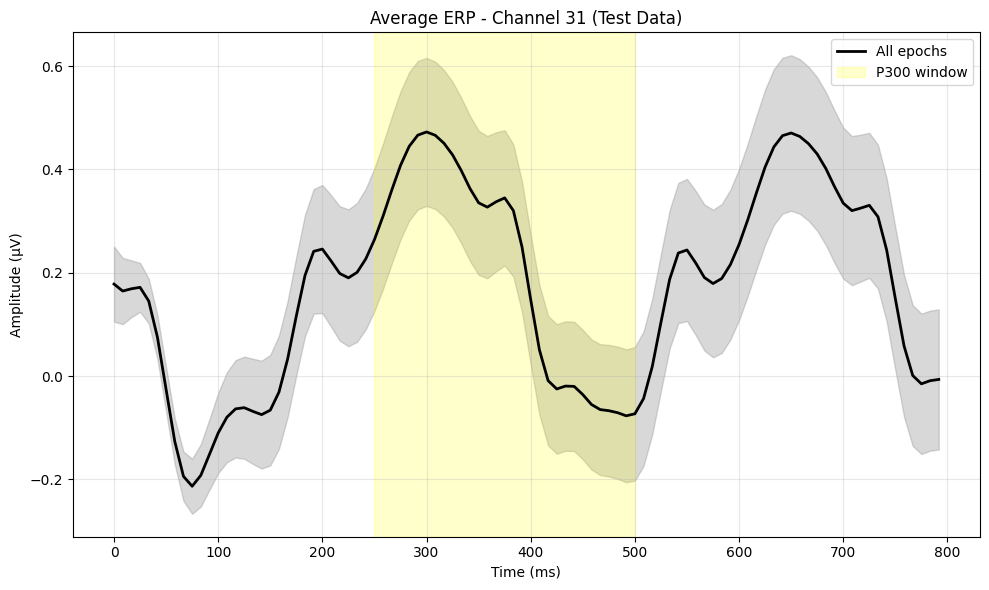


--- Subject B Test ---

Plotting ERP responses for channel 31
  ⚠ No labels available (test data). Plotting all epochs together.


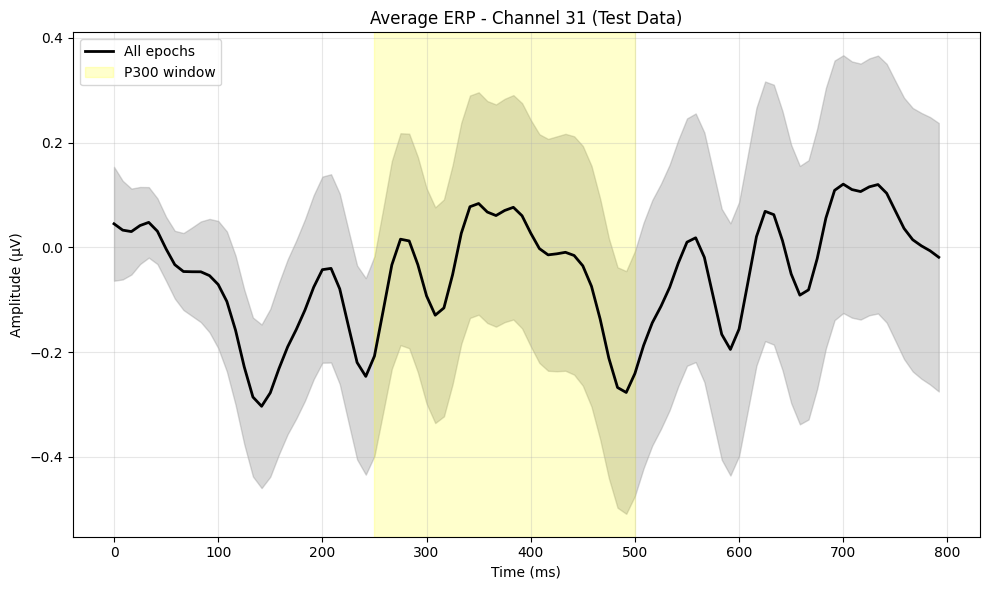

(array([[ 0.08558057,  0.08016305,  0.06677827, ...,  0.2434393 ,
          0.32106989,  0.15649661],
        [ 0.04680942,  0.06909968,  0.0560447 , ...,  0.09455681,
          0.12992107,  0.02751134],
        [ 0.0206937 ,  0.06265858,  0.05620751, ..., -0.01807926,
         -0.02989668, -0.05498483],
        ...,
        [-0.04410135, -0.06620051, -0.09432769, ..., -0.05446899,
          0.0369474 ,  0.0128006 ],
        [-0.07710203, -0.07124049, -0.08754795, ..., -0.0981729 ,
         -0.02246902, -0.0778827 ],
        [-0.10796013, -0.0732356 , -0.08156471, ..., -0.11223011,
         -0.06868558, -0.12993717]]),
 None)

In [10]:
# ========================================================================
# STEP 4: VISUALIZE ERP
# ========================================================================
print("\n" + "="*70)
print("STEP 4: VISUALIZING ERP RESPONSES")
print("="*70)

# Only plot for training data (which has labels)
print("\n--- Subject A Training ---")
plot_erp_responses(train_epochs_A, channel_idx=31, fs=train_proc_A['fs'])

print("\n--- Subject B Training ---")
plot_erp_responses(train_epochs_B, channel_idx=31, fs=train_proc_B['fs'])

# For test data, we can only plot the average
print("\n--- Subject A Test ---")
plot_erp_responses(test_epochs_A, channel_idx=31, fs=test_proc_A['fs'])

print("\n--- Subject B Test ---")
plot_erp_responses(test_epochs_B, channel_idx=31, fs=test_proc_B['fs'])

In [11]:
print("\nData Summary:")
print(f"  Subject A Training: {train_epochs_A['epochs'].shape[0]} epochs")
print(f"  Subject A Test: {test_epochs_A['epochs'].shape[0]} epochs")
print(f"  Subject B Training: {train_epochs_B['epochs'].shape[0]} epochs")
print(f"  Subject B Test: {test_epochs_B['epochs'].shape[0]} epochs")


Data Summary:
  Subject A Training: 7650 epochs
  Subject A Test: 8999 epochs
  Subject B Training: 7650 epochs
  Subject B Test: 8999 epochs


In [12]:
# ========================================================================
# STEP 5: FEATURE EXTRACTION
# ========================================================================
print("\n" + "="*70)
print("STEP 5: FEATURE EXTRACTION")
print("="*70)

# ========================================================================
# Subject A: Compare PCA vs CSP vs Time-Domain
# ========================================================================
print("\n--- Subject A: Feature Comparison ---")

# Try PCA (20 components)
print("\n1. PCA with 20 components:")
X_pca20_A, pca20_A = extract_features(train_epochs_A, method='pca', n_components=20)

# Try PCA (50 components)
print("\n2. PCA with 50 components:")
X_pca50_A, pca50_A = extract_features(train_epochs_A, method='pca', n_components=50)

# Try CSP
print("\n3. CSP with 6 components:")
X_csp_A, csp_filters_A = extract_features(train_epochs_A, method='csp', n_components=6)

# Try Raw Time-Domain Features
print("\n4. Raw Time-Domain Features:")
X_time_A = extract_time_domain_features(train_epochs_A['epochs'])

# Quick comparison with BALANCED LDA
print("\n" + "="*70)
print("QUICK FEATURE COMPARISON USING LDA")
print("="*70)

# Create train/test split for validation
from sklearn.model_selection import train_test_split

# PCA-20 test
if X_pca20_A is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca20_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
    )
    lda_pca20 = train_lda_classifier(X_train, y_train)
    acc_pca20, f1_pca20, _, _ = evaluate_classifier(lda_pca20, X_test, y_test, "PCA-20 LDA")
else:
    acc_pca20 = f1_pca20 = 0

# PCA-50 test
if X_pca50_A is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca50_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
    )
    lda_pca50 = train_lda_classifier(X_train, y_train)
    acc_pca50, f1_pca50, _, _ = evaluate_classifier(lda_pca50, X_test, y_test, "PCA-50 LDA")
else:
    acc_pca50 = f1_pca50 = 0

# CSP test
if X_csp_A is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X_csp_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
    )
    lda_csp = train_lda_classifier(X_train, y_train)
    acc_csp, f1_csp, _, _ = evaluate_classifier(lda_csp, X_test, y_test, "CSP LDA")
else:
    acc_csp = f1_csp = 0

# Time-Domain test
X_train, X_test, y_train, y_test = train_test_split(
    X_time_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
)
lda_time = train_lda_classifier(X_train, y_train)
acc_time, f1_time, _, _ = evaluate_classifier(lda_time, X_test, y_test, "Time-Domain LDA")

# Use LinearSVC (faster than SVM for high-dimensional data) WITH TIMEOUT PROTECTION
print("\n" + "="*70)
print("QUICK FEATURE COMPARISON USING LINEAR SVM")
print("="*70)

import signal
from contextlib import contextmanager
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

class TimeoutException(Exception):
    pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

def quick_svm_test_with_timeout(X, y, feature_name, timeout_seconds=30):
    """Test with LinearSVC with timeout protection"""
    print(f"  Testing {feature_name}...", end=" ")

    try:
        with time_limit(timeout_seconds):
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )

            # For high-dimensional data, use SGDClassifier (faster)
            if X.shape[1] > 1000:  # Time-domain has 6144 features
                print(f"(using SGD for high-dim)", end=" ")
                model = SGDClassifier(
                    loss='hinge',
                    class_weight='balanced',
                    max_iter=1000,
                    random_state=42,
                    n_jobs=-1
                )
            else:
                model = LinearSVC(
                    class_weight='balanced',
                    max_iter=2000,
                    random_state=42,
                    dual=False  # Better for n_samples > n_features
                )

            # Standardize
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            print(f"Done. Acc: {acc:.4f}, F1: {f1:.4f}")
            return acc, f1

    except TimeoutException:
        print(f"TIMEOUT after {timeout_seconds} seconds")
        return 0, 0
    except Exception as e:
        print(f"ERROR: {str(e)[:50]}...")
        return 0, 0

# Test all feature sets with LinearSVC (with timeout)
print("\nLinearSVC Results (with 30-second timeout):")
if X_pca20_A is not None:
    acc_pca20_svm, f1_pca20_svm = quick_svm_test_with_timeout(
        X_pca20_A, train_epochs_A['labels'], "PCA-20", timeout_seconds=30
    )
else:
    acc_pca20_svm, f1_pca20_svm = 0, 0

if X_pca50_A is not None:
    acc_pca50_svm, f1_pca50_svm = quick_svm_test_with_timeout(
        X_pca50_A, train_epochs_A['labels'], "PCA-50", timeout_seconds=30
    )
else:
    acc_pca50_svm, f1_pca50_svm = 0, 0

if X_csp_A is not None:
    acc_csp_svm, f1_csp_svm = quick_svm_test_with_timeout(
        X_csp_A, train_epochs_A['labels'], "CSP", timeout_seconds=30
    )
else:
    acc_csp_svm, f1_csp_svm = 0, 0

# For Time-Domain, use a faster classifier
print("  Testing Time-Domain (using Random Forest instead)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_time_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
)
# Use Random Forest with limited parameters for speed
rf = RandomForestClassifier(
    n_estimators=50,
    class_weight='balanced',
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
acc_time_svm = accuracy_score(y_test, y_pred)
f1_time_svm = f1_score(y_test, y_pred, zero_division=0)
print(f"    Random Forest: Acc: {acc_time_svm:.4f}, F1: {f1_time_svm:.4f}")

print("\n" + "="*70)
print("FEATURE COMPARISON SUMMARY (Subject A)")
print("="*70)
print(f"{'Method':<15} {'LDA Acc':<10} {'LDA F1':<10} {'SVM/RF Acc':<10} {'SVM/RF F1':<10}")
print("-" * 70)
if X_pca20_A is not None:
    print(f"{'PCA-20':<15} {acc_pca20:<10.4f} {f1_pca20:<10.4f} {acc_pca20_svm:<10.4f} {f1_pca20_svm:<10.4f}")
if X_pca50_A is not None:
    print(f"{'PCA-50':<15} {acc_pca50:<10.4f} {f1_pca50:<10.4f} {acc_pca50_svm:<10.4f} {f1_pca50_svm:<10.4f}")
if X_csp_A is not None:
    print(f"{'CSP':<15} {acc_csp:<10.4f} {f1_csp:<10.4f} {acc_csp_svm:<10.4f} {f1_csp_svm:<10.4f}")
print(f"{'Time-Domain':<15} {acc_time:<10.4f} {f1_time:<10.4f} {acc_time_svm:<10.4f} {f1_time_svm:<10.4f}")

# Select best method based on F1-score (prefer SVM/RF F1 when available)
print("\n" + "="*70)
print("SELECTING BEST FEATURE METHOD")
print("="*70)

feature_scores = {}
# Use SVM/RF F1 scores when available and > 0, otherwise use LDA F1
if X_pca20_A is not None:
    f1_score_to_use = f1_pca20_svm if f1_pca20_svm > 0 else f1_pca20
    feature_scores['pca20'] = (f1_score_to_use, pca20_A, f1_pca20_svm, f1_pca20)

if X_pca50_A is not None:
    f1_score_to_use = f1_pca50_svm if f1_pca50_svm > 0 else f1_pca50
    feature_scores['pca50'] = (f1_score_to_use, pca50_A, f1_pca50_svm, f1_pca50)

if X_csp_A is not None:
    f1_score_to_use = f1_csp_svm if f1_csp_svm > 0 else f1_csp
    feature_scores['csp'] = (f1_score_to_use, csp_filters_A, f1_csp_svm, f1_csp)

# Time-Domain: use RF F1 score
f1_score_to_use = f1_time_svm if f1_time_svm > 0 else f1_time
feature_scores['time'] = (f1_score_to_use, None, f1_time_svm, f1_time)

# Print F1 scores for comparison
print("F1-Scores for each method:")
for method, (best_f1, _, svm_f1, lda_f1) in feature_scores.items():
    print(f"  {method:<12}: LDA F1={lda_f1:.4f}, SVM/RF F1={svm_f1:.4f}, Selected={best_f1:.4f}")

best_method = max(feature_scores, key=lambda k: feature_scores[k][0])
best_score, best_feature_obj, svm_f1, lda_f1 = feature_scores[best_method]

print(f"\n✓ Best feature method: {best_method.upper()} (F1-score: {best_score:.4f})")
print(f"  SVM/RF F1: {svm_f1:.4f}, LDA F1: {lda_f1:.4f}")

# ========================================================================
# Subject A: Create final train/val split for later steps
# ========================================================================
print(f"\n--- Subject A: Creating final splits using {best_method.upper()} ---")

# IMPORTANT: Use pre-computed features to avoid recomputation
print("  Using pre-computed features...")

if best_method == 'time':
    X_train_full_A = X_time_A
    feature_method_A = 'time'
    n_components_A = None
    feature_obj_A = None
elif best_method == 'pca20':
    X_train_full_A = X_pca20_A
    feature_obj_A = pca20_A
    n_components_A = 20
    feature_method_A = 'pca'
elif best_method == 'pca50':
    X_train_full_A = X_pca50_A
    feature_obj_A = pca50_A
    n_components_A = 50
    feature_method_A = 'pca'
elif best_method == 'csp':
    X_train_full_A = X_csp_A
    feature_obj_A = csp_filters_A
    feature_method_A = 'csp'
    n_components_A = 6

print(f"  Training features shape: {X_train_full_A.shape}")

# Create train/validation split
X_train_A, X_val_A, y_train_A, y_val_A = train_test_split(
    X_train_full_A, train_epochs_A['labels'], test_size=0.2, random_state=42,
    stratify=train_epochs_A['labels']
)
print(f"Subject A splits: Training={len(X_train_A)}, Validation={len(X_val_A)}")

# Transform test data
print(f"\nTransforming test data using {feature_method_A} method...")

if feature_method_A == 'time':
    X_test_A = test_epochs_A['epochs'].reshape(test_epochs_A['epochs'].shape[0], -1)
    print(f"  Test features shape: {X_test_A.shape}")

elif feature_method_A == 'pca':
    # Flatten test epochs
    test_epochs_flat = test_epochs_A['epochs'].reshape(test_epochs_A['epochs'].shape[0], -1)

    # Standardize using training statistics
    print("  Standardizing test data...")
    scaler = StandardScaler()

    # Fit scaler on training data (already flattened for PCA)
    train_epochs_flat = train_epochs_A['epochs'].reshape(train_epochs_A['epochs'].shape[0], -1)
    scaler.fit(train_epochs_flat)

    test_epochs_scaled = scaler.transform(test_epochs_flat)

    # Apply PCA transformation
    print("  Applying PCA transformation...")
    X_test_A = feature_obj_A.transform(test_epochs_scaled)
    print(f"  Test features shape: {X_test_A.shape}")

else:  # CSP
    print("  Applying CSP transformation...")
    csp_transformer = CSPTransformer(feature_obj_A)
    X_test_A = csp_transformer.transform(test_epochs_A['epochs'])
    print(f"  Test features shape: {X_test_A.shape}")

# ========================================================================
# Subject B: Use same method as Subject A
# ========================================================================
print(f"\n--- Subject B: Feature Extraction using {feature_method_A.upper()} ---")

if feature_method_A == 'time':
    print("  Extracting time-domain features for Subject B...")
    X_train_full_B = extract_time_domain_features(train_epochs_B['epochs'])
    X_test_B = test_epochs_B['epochs'].reshape(test_epochs_B['epochs'].shape[0], -1)
    feature_obj_B = None

elif feature_method_A == 'pca':
    print(f"  Extracting PCA features for Subject B (n_components={n_components_A})...")
    X_train_full_B, pca_B = extract_features(train_epochs_B, method='pca', n_components=n_components_A)
    feature_obj_B = pca_B

    # Transform test data
    print("  Transforming test data...")
    test_epochs_flat = test_epochs_B['epochs'].reshape(test_epochs_B['epochs'].shape[0], -1)
    scaler = StandardScaler()

    # Fit scaler on Subject B training data
    train_epochs_flat = train_epochs_B['epochs'].reshape(train_epochs_B['epochs'].shape[0], -1)
    scaler.fit(train_epochs_flat)

    test_epochs_scaled = scaler.transform(test_epochs_flat)
    X_test_B = pca_B.transform(test_epochs_scaled)

else:  # CSP
    print("  Extracting CSP features for Subject B...")
    X_train_full_B, csp_B = extract_features(train_epochs_B, method='csp', n_components=6)
    feature_obj_B = csp_B

    print("  Transforming test data...")
    csp_transformer = CSPTransformer(csp_B)
    X_test_B = csp_transformer.transform(test_epochs_B['epochs'])

# Create train/validation split for Subject B
print("\n  Creating train/validation split...")
X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(
    X_train_full_B, train_epochs_B['labels'], test_size=0.2, random_state=42,
    stratify=train_epochs_B['labels']
)
print(f"Subject B splits: Training={len(X_train_B)}, Validation={len(X_val_B)}")
print(f"Test features shape: {X_test_B.shape}")

print("\n" + "="*70)
print("FEATURE EXTRACTION COMPLETE!")
print("="*70)
print(f"Selected method: {feature_method_A.upper()}")
print(f"Subject A - Train: {len(X_train_A)}, Val: {len(X_val_A)}, Test: {X_test_A.shape[0]}")
print(f"Subject B - Train: {len(X_train_B)}, Val: {len(X_val_B)}, Test: {X_test_B.shape[0]}")
print(f"Feature dimensions: {X_train_A.shape[1]}")

# Save feature extraction info for later use
feature_info = {
    'method': feature_method_A,
    'n_components': n_components_A,
    'subject_A': {
        'train_shape': X_train_A.shape,
        'val_shape': X_val_A.shape,
        'test_shape': X_test_A.shape,
        'feature_obj': feature_obj_A
    },
    'subject_B': {
        'train_shape': X_train_B.shape,
        'val_shape': X_val_B.shape,
        'test_shape': X_test_B.shape,
        'feature_obj': feature_obj_B
    }
}

print("\nFeature extraction information saved for later steps.")


STEP 5: FEATURE EXTRACTION

--- Subject A: Feature Comparison ---

1. PCA with 20 components:

Extracting features using method: pca
Extracting PCA features (n_components=20)...
  Flattened shape: (7650, 6144)
  PCA features shape: (7650, 20)
  Explained variance ratio: 0.7114

2. PCA with 50 components:

Extracting features using method: pca
Extracting PCA features (n_components=50)...
  Flattened shape: (7650, 6144)
  PCA features shape: (7650, 50)
  Explained variance ratio: 0.8238

3. CSP with 6 components:

Extracting features using method: csp
Extracting CSP features (n_components=6)...
  Target epochs for CSP: 1275
  Non-target epochs for CSP: 6375
  Selected 6 CSP filters
  Eigenvalues of selected filters: [0.7293422  0.69369297 0.66895829 0.37784197 0.36553419 0.33841121]
  CSP features shape: (7650, 6)

4. Raw Time-Domain Features:
Extracting time-domain features...
  Input shape: (7650, 96, 64)
  Output shape: (7650, 6144)
  Features per epoch: 6144

QUICK FEATURE COMPARISO

In [13]:
# ========================================================================
# STEP 6: BASELINE CLASSIFIERS
# ========================================================================
print("\n" + "="*70)
print("STEP 6: BASELINE CLASSIFIERS (Subject A)")
print("="*70)

# Train and evaluate LDA
print("\n1. Linear Discriminant Analysis:")
lda_A = train_lda_classifier(X_train_A, y_train_A)
acc_lda, f1_lda, _, _ = evaluate_classifier(lda_A, X_val_A, y_val_A, "LDA")

# Train and evaluate Logistic Regression
print("\n2. Logistic Regression:")
lr_A = train_logistic_regression(X_train_A, y_train_A)
acc_lr, f1_lr, _, _ = evaluate_classifier(lr_A, X_val_A, y_val_A, "Logistic Regression")


STEP 6: BASELINE CLASSIFIERS (Subject A)

1. Linear Discriminant Analysis:

  Training LDA Classifier...
    Training samples: 6120
    Target: 1020, Non-target: 5100
    Priors: [0.8333, 0.1667]

  Evaluating LDA...
    Accuracy:  0.8333
    Precision: 0.0000
    Recall:    0.0000
    F1-score:  0.0000
    Confusion Matrix:
      [[TN:1275  FP:   0]
       [FN: 255  TP:   0]]
    ROC-AUC:   0.5115

2. Logistic Regression:

  Training Logistic Regression...
    Training samples: 6120
    Target: 1020, Non-target: 5100
    Coefficients shape: (1, 6)

  Evaluating Logistic Regression...
    Accuracy:  0.5327
    Precision: 0.1788
    Recall:    0.5020
    F1-score:  0.2636
    Confusion Matrix:
      [[TN: 687  FP: 588]
       [FN: 127  TP: 128]]
    ROC-AUC:   0.5145


In [14]:
# ========================================================================
# STEP 7: CLASSICAL ML MODELS
# ========================================================================
print("\n" + "="*70)
print("STEP 7: CLASSICAL MACHINE LEARNING (Subject A)")
print("="*70)

# Compare all classical models
results_classical_A, models_A = compare_all_classical_models(
    X_train_A, y_train_A, X_val_A, y_val_A
)

# Train SVM for both subjects (usually the best model)
print("\n" + "="*70)
print("TRAINING FINAL SVM MODELS")
print("="*70)

print("\n--- Subject A SVM ---")
svm_A, scaler_A = train_svm_classifier(X_train_A, y_train_A, kernel='rbf', C=1.0)

print("\n--- Subject B SVM ---")
svm_B, scaler_B = train_svm_classifier(X_train_B, y_train_B, kernel='rbf', C=1.0)

# Evaluate final SVM models
print("\n" + "="*70)
print("FINAL SVM EVALUATION")
print("="*70)

print("\n--- Subject A SVM Validation ---")
X_val_A_scaled = scaler_A.transform(X_val_A)
evaluate_classifier(svm_A, X_val_A_scaled, y_val_A, "Subject A SVM")

print("\n--- Subject B SVM Validation ---")
X_val_B_scaled = scaler_B.transform(X_val_B)
evaluate_classifier(svm_B, X_val_B_scaled, y_val_B, "Subject B SVM")


STEP 7: CLASSICAL MACHINE LEARNING (Subject A)

COMPARING CLASSICAL ML MODELS

Training LDA

  Training LDA Classifier...
    Training samples: 6120
    Target: 1020, Non-target: 5100
    Priors: [0.8333, 0.1667]

LDA Results:
  Accuracy:  0.8333
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000
  ROC-AUC:   0.5115

Training Logistic Regression

  Training Logistic Regression...
    Training samples: 6120
    Target: 1020, Non-target: 5100
    Coefficients shape: (1, 6)

Logistic Regression Results:
  Accuracy:  0.5327
  Precision: 0.1788
  Recall:    0.5020
  F1-score:  0.2636
  ROC-AUC:   0.5145

Training SVM (RBF)

  Training SVM Classifier (kernel=rbf, C=1.0)...
    Training samples: 6120
    Target: 1020, Non-target: 5100
    Support vectors per class: [4788  981]

SVM (RBF) Results:
  Accuracy:  0.5196
  Precision: 0.1639
  Recall:    0.4588
  F1-score:  0.2415
  ROC-AUC:   0.5093

Training SVM (Linear)

  Training SVM Classifier (kernel=linear, C=1.0)...
    Training 

(0.5784313725490197,
 0.2825361512791991,
 0.1972049689440994,
 0.4980392156862745)

In [15]:
# ========================================================================
# STEP 8: EXPORT MODELS
# ========================================================================
print("\n" + "="*70)
print("STEP 8: EXPORTING MODELS")
print("="*70)

import os

# Create models directory
os.makedirs('models', exist_ok=True)

# Save Subject A model
save_model({
    'model': svm_A,
    'scaler': scaler_A,
    'feature_extractor': feature_obj_A,
    'feature_method': feature_method_A,
    'n_components': n_components_A,
    'training_info': {
        'samples': len(X_train_A),
        'features': X_train_A.shape[1],
        'target_ratio': np.mean(y_train_A)
    }
}, 'models/subject_A_svm.pkl')

# Save Subject B model
save_model({
    'model': svm_B,
    'scaler': scaler_B,
    'feature_extractor': feature_obj_B,
    'feature_method': feature_method_A,
    'n_components': n_components_A,
    'training_info': {
        'samples': len(X_train_B),
        'features': X_train_B.shape[1],
        'target_ratio': np.mean(y_train_B)
    }
}, 'models/subject_B_svm.pkl')

# Also save the best baseline model (LDA)
save_model({
    'model': lda_A,
    'feature_method': feature_method_A,
    'feature_extractor': feature_obj_A
}, 'models/subject_A_lda.pkl')

print("\n" + "="*70)
print("PIPELINE COMPLETE!")
print("="*70)
print("\nSummary:")
print(f"1. Data loaded and preprocessed for 2 subjects")
print(f"2. Epochs extracted: Training={train_epochs_A['epochs'].shape[0]:,} per subject")
print(f"3. Best feature method: {feature_method_A.upper()}")
print(f"4. Models trained and saved to 'models/' directory")
print(f"5. Ready for prediction on test data!")


STEP 8: EXPORTING MODELS

  Model saved to: models/subject_A_svm.pkl

  Model saved to: models/subject_B_svm.pkl

  Model saved to: models/subject_A_lda.pkl

PIPELINE COMPLETE!

Summary:
1. Data loaded and preprocessed for 2 subjects
2. Epochs extracted: Training=7,650 per subject
3. Best feature method: CSP
4. Models trained and saved to 'models/' directory
5. Ready for prediction on test data!
